## Goal... test training schemes
Test: Using $ W_{\mathrm{res}}\in\mathbb{R}^{N\times N} $ we take $ N $ steps before getting the loss $ \mathcal{L} $, on $ N+1 $ only, before backprop. This is motivated by work in Chaos paper. The max reservoir memory is $ t-N $ time-steps to predict the next step $ t+1 $.

In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/exESN/ESN_utils/')
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import ESN_util.rc_tools as rct
import ESN_util.rc_analysis as rca

from itertools import chain 
from torchviz import make_dot, make_dot_from_trace

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import pdb 
import time
from jupyterthemes import jtplot
jtplot.style()

def grad_printer(model: nn.Module) -> nn.Module:
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: print(f'{grad}'))
    return model

In [2]:
DEV = 'cuda:6'
DTYPE = torch.float32 
#torch.set_num_interop_threads(4)
torch.set_num_threads(4)

In [3]:
K = 1
N = 30
L = 1
TRAIN = 14000

In [10]:
class Pmul(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a, g):
        ctx.save_for_backward(a,g)
        return torch.mul(a,g)

    @staticmethod
    def backward(ctx, grad_output):
        a,g = ctx.saved_tensors
        da = grad_output*g 
        dg = grad_output*a
        return da, dg

class Clamp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return input.clamp(min=0, max=1) # the value in iterative = 2

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.clone()

class Leaky_Tanh(nn.Module):
    def __init__(self, N):
        """
        Initialize learnable parameters:
        alpha = controls influence of past information
        gamma = controls amplitude from nonlinear term
        """
        super(Leaky_Tanh,self).__init__()
        self.pmul = Pmul.apply
        self.clamp = Clamp.apply
        self.a = Parameter(torch.mul(torch.ones(1,N),.5))
        self.g = Parameter(torch.rand(1,N))
        
    def forward(self, xt, zt): 
        self.clamp(self.a)
        return (1-self.a)*xt + self.pmul(self.a,self.g)*torch.tanh(xt+zt) 
    
class SymESN(nn.Module):
    def __init__(self, k, n, l, r, rho):
        super(SymESN, self).__init__()

        self.N = n
        self.Q, self.d, self.Qt = self.initRes(r, rho)
        self.D = Parameter(self.d)
        self.Rin = nn.Linear(k, self.N, bias=False)
        self.Lky = Leaky_Tanh(self.N)
        self.Rout = nn.Linear(self.N+k,l, bias=False)

    def forward(self, hidden, ut):
        zt = self.Rin(ut)
        ht = torch.matmul(hidden,torch.matmul(self.Q, torch.matmul(torch.diag(self.D), self.Qt)))#self.Res(hidden)
        ht1 = self.Lky(ht,zt)
        out = self.Rout(torch.cat((ht1,ut),1))
        return ht1, out

    def packState(self, h=None):
        if(not h):
            h = torch.randn(1, self.N)
        else:
            h = h.detach_()
        return h
    def initRes(self, r, rho):
        A = torch.mul(torch.sub(torch.rand((self.N,self.N)),.5),2.)
        W = (A + torch.transpose(A,0,1))-torch.diag(torch.diagonal(A))
        eigmax = torch.max(torch.abs(torch.linalg.eigvals(W)))
        Wszd = torch.mul(torch.div(W,eigmax),rho)
        D,Q = torch.linalg.eig(Wszd)
        return torch.real(Q).cuda(DEV), torch.real(D).cuda(DEV), torch.real(torch.transpose(Q,0,1)).cuda(DEV)

esn = SymESN(K,N,L,1.0,.6).float().cuda(DEV)
print(esn)
for n,p in esn.named_parameters():
    print(n)

SymESN(
  (Rin): Linear(in_features=1, out_features=30, bias=False)
  (Lky): Leaky_Tanh()
  (Rout): Linear(in_features=31, out_features=1, bias=False)
)
D
Rin.weight
Lky.a
Lky.g
Rout.weight


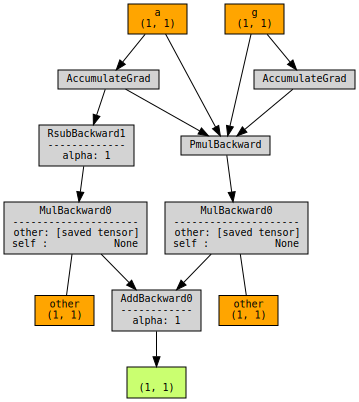

In [11]:
xt = torch.Tensor([[.1]])
ut = torch.Tensor([[.5]])
lky = Leaky_Tanh(1)
l = lky(xt,ut)

make_dot(l, params=dict(lky.named_parameters()), show_attrs=True, show_saved=True)

In [6]:
#make_dot(yhat, params=dict(esn.named_parameters()), show_attrs=True, show_saved=True)

In [12]:
FREERUN = 20
DT = .02
rho = 28.0
sigma = 10.0
beta = 8/3
BATCH = 10

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

def  lorenz63(batch, length, delta=.02, x0_range=5):
    arrs = []
    for b in range(batch):
        state0 = np.array([1.,1.,1.])+np.random.randn(3)*x0_range
        t = np.arange(0,length,delta)
        states = odeint(f,state0,t)
        muX = np.mean(states[:], axis=0)
        arrs.append((states-muX).T)
    return np.array(arrs)

#(batch,dim,data_len)
#signal = torch.tensor(states[:TRAIN,0]-muX, device=DEV).float()
        
X = lorenz63(BATCH, 300+FREERUN, .02, x0_range=1.0)
targets = torch.tensor(X[:,0,:],  device=DEV).float()

#state0 = [1.,1.,1.]
#t = np.arange(0,300+FREERUN,DT)
#states = odeint(f,state0,t)
#muX = np.mean(states[:,0])
#signal = torch.tensor(states[:TRAIN,0]-muX, device=DEV).float()

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(esn.parameters(),lr=.001)

In [ ]:
EPOCHS = 5
alphas = np.zeros((EPOCHS*BATCH,N))
gammas = np.zeros((EPOCHS*BATCH,N))
Agrad = np.zeros((EPOCHS*BATCH,N))
Ggrad = np.zeros((EPOCHS*BATCH,N))
SRgrad = np.zeros((EPOCHS*BATCH,N))
eigs = np.zeros((EPOCHS*BATCH,N))
epoch_loss = np.zeros(EPOCHS*BATCH)
torch.autograd.set_detect_anomaly(True)
for s in range(BATCH):
    signal = targets[s,:TRAIN]
    start = time.time()
    for ep in range(EPOCHS):
        print(f'Epoch: {ep} Batch: {s}  {ep+(s*ep)}')
        preds = np.zeros(TRAIN)
        xt = esn.packState().cuda(DEV)
        running_loss = 0.
        loss = 0.
        for i in range(TRAIN-N):
            y = signal[i+N].view(1,1)
            optimizer.zero_grad()
            for j in range(i,i+N):  # Go N steps and make the i+N+1 prediction
                ut = signal[j].view(1,1)  # Next forcing
                xt1, yhat = esn(xt,ut)
                xt = xt1  # Feedback state
            loss = criterion(yhat,y)  # Backprop from last pred only
            preds[i+N] = yhat.detach().cpu().numpy()[0,0] # Preds should start at N going to TRAIN
            running_loss += loss.item()
            loss.backward(retain_graph=False)
            if(i==TRAIN-N-1):
                Agrad[(s*EPOCHS)+ep] = esn.Lky.a.grad[0,:].cpu().detach().numpy() 
                Ggrad[(s*EPOCHS)+ep] = esn.Lky.g.grad[0,:].cpu().detach().numpy()  
                SRgrad[(s*EPOCHS)+ep] = esn.D.grad[:].cpu().detach().numpy()  
            optimizer.step()
            xt = esn.packState().cuda(DEV)
        eigs[(s*EPOCHS)+ep] = esn.D.data[:].cpu().detach().numpy()   # Value of D
        alphas[(s*EPOCHS)+ep] = esn.Lky.a.data[:].cpu().detach().numpy() 
        gammas[(s*EPOCHS)+ep] = esn.Lky.g.data[:].cpu().detach().numpy()  
        epoch_loss[(s*EPOCHS)+ep] = running_loss/(TRAIN-N)
        print(epoch_loss[ep])
        if(ep%(EPOCHS-1)==0):
            print(f'Epoch: {ep}')
            target = signal.detach().cpu().numpy()
            plt.figure(figsize=(15,16))
            ax1 = plt.subplot(421)
            ax1.set_title('Target and Predictions')
            ax1.plot(target, label='tar')
            ax1.plot(preds, label='pred')
            ax1.set_ylim(-25,25)
            

            ax2 = plt.subplot(422)
            ax2.set_title('Eigenvalues in D')
            for i in range(eigs.shape[1]):
                ax2.plot(eigs[:,i],label=f'eig{i}')
            ax2.set_ylim(-2,2)
            

            ax3 = plt.subplot(423)
            ax3.set_title('Value of Alpha')
            for i in range(alphas.shape[1]):
                ax3.plot(alphas[:,i], label=f'alpha{i}')
            ax3.set_ylim(-3,3)
            

            ax4 = plt.subplot(424)
            ax4.set_title('Value of Gamma')
            for i in range(gammas.shape[1]):
                ax4.plot(gammas [:,i], label=f'gamma{i}')
            ax4.set_ylim(-3,3)
            

            ax5 = plt.subplot(425)
            ax5.set_title('Alpha Gradients')
            for i in range(Agrad.shape[1]):
                ax5.plot(Agrad[:,i], label=f'A{i}')
            ax5.set_ylim(-2,2)
            

            ax6 = plt.subplot(426)
            ax6.set_title('Gamma Gradients')
            for i in range(Ggrad.shape[1]):
                ax6.plot(Ggrad[:,i], label=f'G{i}')
            ax6.set_ylim(-1,1)
            


            ax7 = plt.subplot(427)
            ax7.set_title('Gradients of Diagonal Matrix')
            for i in range(SRgrad.shape[1]):
                ax7.plot(SRgrad[:,i], label=f'SR{i}')
            ax7.set_ylim(-5,5)
            

            ax8 = plt.subplot(428)
            ax8.set_title('Ave Loss Per Epoch')
            ax8.plot(epoch_loss, label=f'ave loss')
            plt.tight_layout()
            plt.show()
            plt.close()
    print(f'Time to run epoch: {time.time()-start}  Target data {s}')

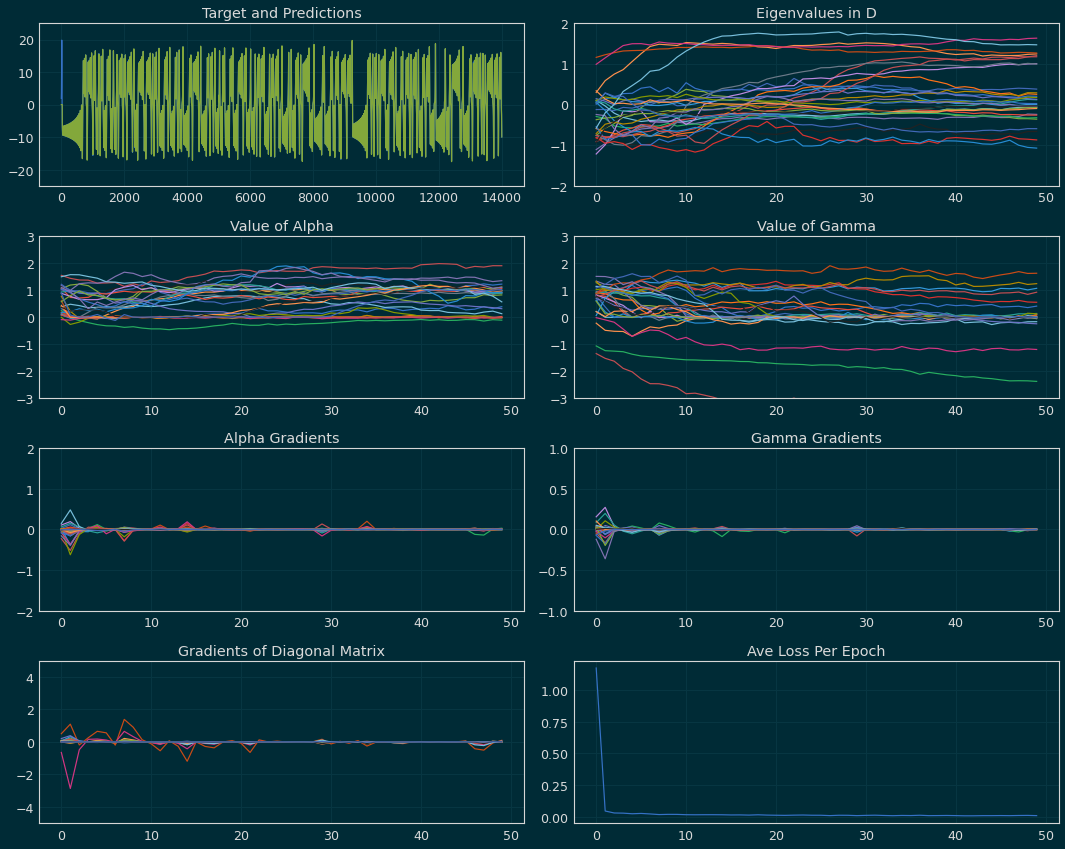

In [15]:
plt.figure(figsize=(15,12))
ax1 = plt.subplot(421)
ax1.set_title('Target and Predictions')
ax1.plot(target, label='tar')
ax1.plot(preds, label='pred')
ax1.set_ylim(-25,25)


ax2 = plt.subplot(422)
ax2.set_title('Eigenvalues in D')
for i in range(eigs.shape[1]):
    ax2.plot(eigs[:,i],label=f'eig{i}')
ax2.set_ylim(-2,2)


ax3 = plt.subplot(423)
ax3.set_title('Value of Alpha')
for i in range(alphas.shape[1]):
    ax3.plot(alphas[:,i], label=f'alpha{i}')
ax3.set_ylim(-3,3)


ax4 = plt.subplot(424)
ax4.set_title('Value of Gamma')
for i in range(gammas.shape[1]):
    ax4.plot(gammas [:,i], label=f'gamma{i}')
ax4.set_ylim(-3,3)


ax5 = plt.subplot(425)
ax5.set_title('Alpha Gradients')
for i in range(Agrad.shape[1]):
    ax5.plot(Agrad[:,i], label=f'A{i}')
ax5.set_ylim(-2,2)


ax6 = plt.subplot(426)
ax6.set_title('Gamma Gradients')
for i in range(Ggrad.shape[1]):
    ax6.plot(Ggrad[:,i], label=f'G{i}')
ax6.set_ylim(-1,1)



ax7 = plt.subplot(427)
ax7.set_title('Gradients of Diagonal Matrix')
for i in range(SRgrad.shape[1]):
    ax7.plot(SRgrad[:,i], label=f'SR{i}')
ax7.set_ylim(-5,5)


ax8 = plt.subplot(428)
ax8.set_title('Ave Loss Per Epoch')
ax8.plot(epoch_loss, label=f'ave loss')
plt.tight_layout()
plt.show()
plt.close()

In [16]:
#torch.save({'model' : esn.state_dict(),
#            'optimizer' : optimizer.state_dict(), 
#            'Qmat' : esn.Q},
#           './Data/SavedModels/model_AD3.pt')
#esn_dict = torch.load('./Data/SavedModels/batch10_AD3')

In [18]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in esn.state_dict():
    print(param_tensor, "\t", esn.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
D 	 torch.Size([30])
Rin.weight 	 torch.Size([30, 1])
Lky.a 	 torch.Size([1, 30])
Lky.g 	 torch.Size([1, 30])
Rout.weight 	 torch.Size([1, 31])
Optimizer's state_dict:
state 	 {0: {'step': 698500, 'exp_avg': tensor([-1.7733e-03,  9.4955e-04,  5.1017e-03, -1.1329e-03,  8.0354e-03,
         7.6335e-06, -1.6159e-05,  1.6223e-04,  4.5398e-04,  2.9221e-04,
         2.6193e-03, -1.4828e-04, -6.4926e-05,  2.1408e-03, -1.4378e-05,
         4.8956e-04,  9.6708e-05,  3.3461e-02, -8.1986e-05,  2.1877e-03,
         8.7980e-05,  9.6851e-03,  1.9900e-03,  1.7152e-04,  8.5674e-03,
         6.5599e-04, -8.6927e-04,  1.5422e-02,  1.7179e-03,  5.9051e-04],
       device='cuda:6'), 'exp_avg_sq': tensor([4.8622e-02, 1.9851e-02, 6.4571e-03, 1.7777e-02, 1.9972e-02, 1.1785e-02,
        4.6448e-04, 2.7136e-04, 7.3846e-03, 9.2794e-03, 1.9167e-03, 6.6744e-04,
        5.8242e-04, 1.7335e-03, 1.3506e-04, 2.2505e-03, 1.0125e-03, 2.9648e-01,
        2.2055e-03, 1.1442e-03, 8.7190e-03, 3.4727e-02

In [ ]:
eigenvalues = esn_dict['model']['D'].cpu().numpy()
eigsorted = np.argsort(np.abs(eigenvalues))
plt.stem(np.abs(eigenvalues[eigsorted]), label='sorted')
plt.legend()
plt.show()

print(f'Sum of eignvals {np.sum(eigenvalues)}')

In [ ]:
Alphas = esn_dict['model']['Lky.a'].detach().cpu().numpy()
plt.stem(np.squeeze(Alphas), label='alpha')
plt.legend()
plt.show()

In [ ]:
Gammas = esn_dict['model']['Lky.g'].detach().cpu().numpy()
plt.stem(np.squeeze(Gammas), label='gamma')
plt.legend()
plt.show()

In [ ]:
D = np.diag(eigenvalues)
Q = esn_dict['Qmat'].detach().cpu().numpy()
Qt = np.transpose(Q)
Wr = np.dot(Q,np.dot(D,Qt))

In [ ]:
Wi = esn_dict['model']['Rin.weight'].detach().cpu().numpy()
A = rca.leaky_jacobian(np.zeros((N,K)), np.zeros((K,K)), Alphas.T, Gammas.T, Wi, Wr)
B = rca.partial_u(np.zeros((N,K)), np.zeros((K,K)), Alphas.T, Gammas.T, Wi, Wr)
Cn = rca.reachable_matrix(A,B)
Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))

In [ ]:
def rank_curve(Mat, tols):
    return rca.rank(Mat,tols) 

def rank_max_grad(curve):
    return np.argmax(np.gradient(curve))

tolerances = [1/10**x for x in range(0,20)]
ranks = rank_curve(Cn,tolerances)
idx = rank_max_grad(ranks)
print(f'Ave rank for largest gradient {(ranks[idx]+ranks[idx])/2}')

In [ ]:
plt.stem(eigenvalues[eigsorted]**20, label='sorted')
plt.legend()
plt.show()

In [ ]:
eigenvalues

In [ ]:
Q = esn_dict['Qmat']
Q = Q.detach().cpu().numpy()
D = np.diag(eigenvalues)
Wr = np.dot(Q, np.dot(D,Q.T))

In [ ]:
plt.figure()
for i in range(Wr.shape[0]):
    plt.plot(Q[:,i])
plt.show()
plt.close()